## Problem Statement
Visually impaired individuals face significant challenges in identifying currency notes, leading to financial dependence and vulnerability to fraud.This project aims to develop an **Indian currency note classification system** using Convolutional Neural Networks integrated with audio feedback to help blind users recognize Indian currency notes independently.The model will be trained on a dataset containing images of different denominations to classify them correctly. The system can be useful in **automated cash handling machines, ATMs, and banking security**.



# 🧠 Convolutional Neural Network (CNN) Project

## 👥 Team Members and Individual Contributions
### 1️⃣ **K G Lakssan** - Data Preprocessing & Augmentation 
### 2️⃣ **Jaiviswesh** - Model Architecture & Training  
### 3️⃣ **Mohit** - Evaluation & Performance Metrics 
### 4️⃣ **Yukeshwar** - Deployment & Visualization  

In [60]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import PIL
from PIL import _imaging
from PIL import Image
from tensorflow.keras.models import load_model
import numpy as np
from glob import glob

The dataset we used is **Indian Currency Note images dataset 2020** it contains images of **Indian currency notes** categorized by denomination (₹10, ₹20, ₹50, ₹100, ₹200, ₹500, ₹2000). It is divided into:
- **Training Set**: Used for model training
- **Testing Set**: Used for performance evaluation
Each image is preprocessed (resized to 224x224) before being passed to the CNN model.

In [35]:

train_path = r"C:\Users\K.G.LAKSSAN\OneDrive\Documents\NNDL Project\Indian-Currency-Notes-Classifier\Indian currency dataset v1\training"
valid_path = r"C:\Users\K.G.LAKSSAN\OneDrive\Documents\NNDL Project\Indian-Currency-Notes-Classifier\Indian currency dataset v1\test"

In [6]:
folders = glob(r"C:\Users\K.G.LAKSSAN\OneDrive\Documents\NNDL Project\Indian-Currency-Notes-Classifier\Indian currency dataset v1\training\*")

In [8]:
labels = ['10','20','50','100','200','500','2000'] 

In [10]:
folders

['C:\\Users\\K.G.LAKSSAN\\OneDrive\\Documents\\NNDL Project\\Indian-Currency-Notes-Classifier\\Indian currency dataset v1\\training\\10',
 'C:\\Users\\K.G.LAKSSAN\\OneDrive\\Documents\\NNDL Project\\Indian-Currency-Notes-Classifier\\Indian currency dataset v1\\training\\100',
 'C:\\Users\\K.G.LAKSSAN\\OneDrive\\Documents\\NNDL Project\\Indian-Currency-Notes-Classifier\\Indian currency dataset v1\\training\\20',
 'C:\\Users\\K.G.LAKSSAN\\OneDrive\\Documents\\NNDL Project\\Indian-Currency-Notes-Classifier\\Indian currency dataset v1\\training\\200',
 'C:\\Users\\K.G.LAKSSAN\\OneDrive\\Documents\\NNDL Project\\Indian-Currency-Notes-Classifier\\Indian currency dataset v1\\training\\2000',
 'C:\\Users\\K.G.LAKSSAN\\OneDrive\\Documents\\NNDL Project\\Indian-Currency-Notes-Classifier\\Indian currency dataset v1\\training\\50',
 'C:\\Users\\K.G.LAKSSAN\\OneDrive\\Documents\\NNDL Project\\Indian-Currency-Notes-Classifier\\Indian currency dataset v1\\training\\500']

## Data Preprocessing
To enhance model performance, the following preprocessing steps were applied:
- **Resizing** images to 224x224 pixels.
- **Normalization** (scaling pixel values between 0 and 1).
- **Data Augmentation** (rotation, flipping) to improve generalization.

In [39]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   height_shift_range=0.2,
                                   featurewise_center=True,
                                   rotation_range=0.4,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [16]:
training_set = train_datagen.flow_from_directory(r"C:\Users\K.G.LAKSSAN\OneDrive\Documents\NNDL Project\Indian-Currency-Notes-Classifier\Indian currency dataset v1\training",
                                                 target_size = (224, 224),
                                                 classes = labels,
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 2604 images belonging to 7 classes.


In [37]:
test_set = test_datagen.flow_from_directory(r"C:\Users\K.G.LAKSSAN\OneDrive\Documents\NNDL Project\Indian-Currency-Notes-Classifier\Indian currency dataset v1\validation",
                                            target_size = (224, 224),
                                            classes = labels,
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle=False
                                           )

Found 249 images belonging to 7 classes.


## Hyperparameter Tuning
We optimized:
- **Learning Rate**: [0.01, 0.001, 0.0001]
- **Number of CNN Layers**: [1, 2, 3]
- **Filters in CNN Layers**: [32, 64, 128]
- **Dropout Rate**: [0.2 - 0.5]
- **Dense Layer Units**: [64, 128, 256]

Best configration:


In [85]:
import tensorflow as tf
from tensorflow import keras
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = keras.Sequential()
    
    model.add(keras.layers.Conv2D(
        filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    for i in range(hp.Int('num_conv_layers', 1, 3)):\
        model.add(keras.layers.Conv2D(
            filters=hp.Int(f'conv{i+2}_filters', min_value=32, max_value=128, step=32),
            kernel_size=(3, 3), activation='relu'))
        model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(keras.layers.Flatten())
    
    model.add(keras.layers.Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu'))
    model.add(keras.layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(keras.layers.Dense(7, activation='softmax'))  
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5, 
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='currency_detection'
)


tuner.search(training_set, validation_data=test_set, epochs=10)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best hyperparameters:
- Learning Rate: {best_hps.get('learning_rate')}
- First Conv Layer Filters: {best_hps.get('conv1_filters')}
- Number of Conv Layers: {best_hps.get('num_conv_layers')}
- Dense Layer Units: {best_hps.get('dense_units')}
- Dropout Rate: {best_hps.get('dropout_rate')}
""")

Trial 2 Complete [00h 41m 58s]
val_accuracy: 0.1325301229953766

Best val_accuracy So Far: 0.8875501751899719
Total elapsed time: 01h 05m 55s

Best hyperparameters:
- Learning Rate: 0.001
- First Conv Layer Filters: 64
- Number of Conv Layers: 3
- Dense Layer Units: 192
- Dropout Rate: 0.30000000000000004



In [62]:
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 192)                 │      38,535,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 7)                   │           1,351 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,612,359 (147.29 MB)

 Trainable params: 38,612,359 (147.29 MB)

 Non-trainable params: 0 (0.00 B)

In [94]:
r = best_model.fit(
  training_set,
  validation_data=test_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)
best_model.save('model_Classifier.keras')

Epoch 1/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.1672 - loss: 2.5130 - val_accuracy: 0.3133 - val_loss: 1.6233
Epoch 2/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 425s 5s/step - accuracy: 0.3310 - loss: 1.6557 - val_accuracy: 0.4618 - val_loss: 1.4175
Epoch 3/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.4828 - loss: 1.3570 - val_accuracy: 0.4980 - val_loss: 1.2875
Epoch 4/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.5605 - loss: 1.1245 - val_accuracy: 0.6426 - val_loss: 0.9612
Epoch 5/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.6461 - loss: 0.9543 - val_accuracy: 0.7349 - val_loss: 0.7464
Epoch 6/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.6905 - loss: 0.8247 - val_accuracy: 0.7550 - val_loss: 0.6929
Epoch 7/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.7358 - loss: 0.7344 - val_accuracy: 0.7550 - val_loss: 0.6507
Epoch 8/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.7453 - loss: 0.6877 - val_accuracy: 0.8032 - v

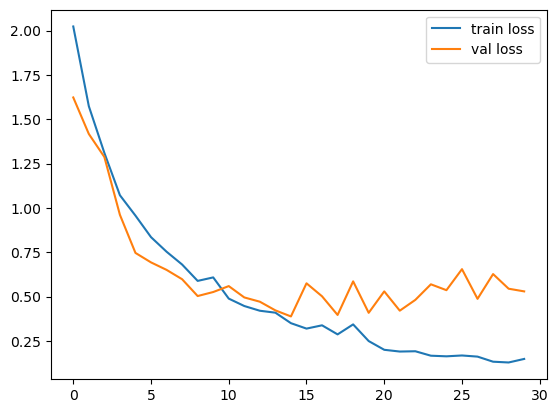

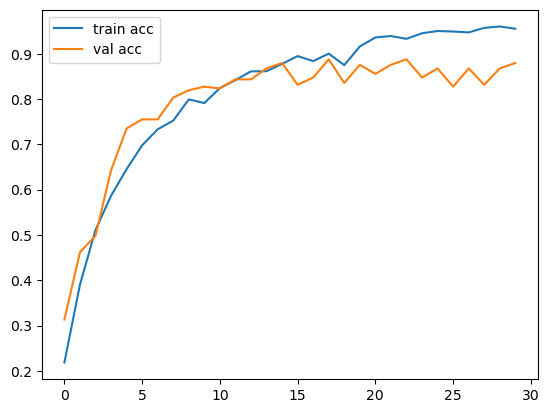

In [96]:
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [223]:
y_pred = best_model.predict(test_set)
y_pred_class = np.argmax(y_pred, axis=1)
y_true = test_set.classes 

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


## Evaluation Metrics
The model's performance was measured using:
- **Accuracy**: Measures overall correctness.
- **Classification Report**: Evaluates per-class performance.
- **Confusion Matrix**: Visualizes misclassifications.

In [224]:
accuracy = accuracy_score(y_true, y_pred_class)
print(f"Model Accuracy: {accuracy * 100:.2f}%\n")

Model Accuracy: 91.40%



In [186]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred_class, target_names=test_set.class_indices.keys()))

Classification Report:

              precision    recall  f1-score   support

          10       1.00      0.78      0.88        32
          20       0.75      0.75      0.75        28
          50       0.84      0.93      0.88        40
         100       0.93      0.97      0.95        38
         200       0.97      0.97      0.97        33
         500       0.97      0.89      0.93        38
        2000       0.91      1.00      0.95        40

    accuracy                           0.91       249
   macro avg       0.91      0.90      0.90       249
weighted avg       0.91      0.91      0.91       249



<Axes: >

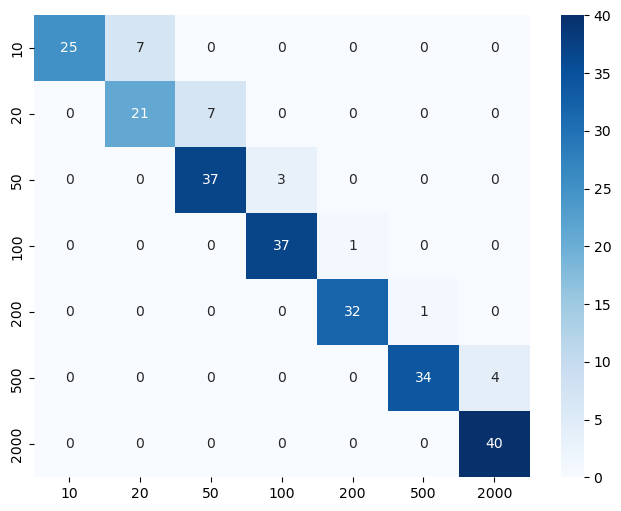

In [188]:
cm = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_set.class_indices.keys(), yticklabels=test_set.class_indices.keys())

In [140]:
def predict_note(img):
    test_image=image.img_to_array(img)
    test_image=np.expand_dims(test_image, axis = 0)
    result = Classifier.predict(test_image)
    if result[0][0] == 1:
        prediction = "10"
    elif result[0][1] == 1:
        prediction = "20"
    elif result[0][2] == 1:
        prediction = "50"
    elif result[0][3] == 1:
        prediction = "100"
    elif result[0][4] == 1:
        prediction = "200"
    elif result[0][5] == 1:
        prediction = "500"
    elif result[0][6] == 1:
        prediction = "2000"
    print("Predicted class: ",prediction)


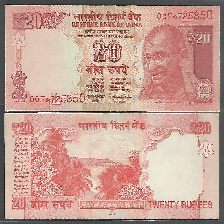

In [215]:
img=image.load_img(r'C:\Users\K.G.LAKSSAN\OneDrive\Documents\NNDL Project\Indian-Currency-Notes-Classifier\Test\20\2.jpg',target_size=(224,224))
img

In [227]:
predict_note(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted class:  20
